# Informe de desempeño de PROESUR años 2015 - 2024

Este informe consta del desempeño del campus PROESUR desde el año 2015 hasta el año 2024. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
FOLDER = Path("data")  
OUTPUT = Path("Extracted_data")

In [3]:
def load_small_chunks(path: Path, col: str = "Cod_Estable",code: str = "05-02-0232-46") -> pd.DataFrame:
    '''
    Extracts only the data we want from each xlsx file 
    ''' 
    df = pd.read_excel(path, engine="openpyxl")
    df = df[df[col] == code]
    return df

def concat_dataframes(files: list[Path]) -> pd.DataFrame | None:
    df_list: list[pd.DataFrame] = []
    for f in files:
        df_list.append(load_small_chunks(f))
    try:
        result = pd.concat(df_list, ignore_index=True)
        return result
    except Exception as e:
        print(f"Error: {e}")
        return None
 

In [4]:
def load_small_chunks_multiple(path: Path, col: str = "Cod_Estable", code: str = "05-02-0232-46") -> pd.DataFrame:
    """Read first sheet, keep ALL columns, filter by the first alias that exists."""
    df = pd.read_excel(path, engine="openpyxl", dtype=str)  # keep as strings
    try: 
        df = df[df[col] == code]  
    except Exception:
        df = df[df[col] == code]
        return df
    else:
        return df

    

In [5]:

# for f in sorted(FOLDER.glob("*.xlsx"), reverse=True):
#     df = load_small_chunks_multiple(f)
#     if not df.empty:
#         df.to_csv(OUTPUT / f"{f.stem}_filtered.csv", index=False)
#     else:
#         print(f"{f.stem} was empty")


In [5]:
def search_by_value(path: Path, val:str, col:str) -> pd.DataFrame:
    df = pd.read_excel(path, engine="openpyxl")
    mask = df[col].astype(str).str.contains(val, case=False, na=False)
    return df.loc[mask]


def search_by_map(path: Path, query: dict[str, str], op: str = "AND") -> pd.DataFrame:
    """
    query: {"NOM_ESTAB": "INSTITUTO", "Municipio": "Guatemala"}
    op: "AND" or "OR"
    """
    df = pd.read_excel(path, engine="openpyxl", dtype=str)
    masks = []
    for col, val in query.items():
        if col in df.columns:
            m = df[col].astype(str).str.contains(val, case=False, na=False)
            masks.append(m)
    if not masks:
        return df.iloc[0:0]
    if op.upper() == "OR":
        mask = masks[0]
        for m in masks[1:]: mask = mask | m
    else:
        mask = masks[0]
        for m in masks[1:]: mask = mask & m
    return df.loc[mask]


In [7]:
# FILES = ["GRADUANDOS 2015.xlsx", "GRADUANDOS 2016.xlsx"]

# for fname in FILES:
#     file_path = FOLDER / fname
#     if not file_path.exists():
#         print(f"File not found: {file_path}")
#         continue
#     result = search_by_value(file_path, "INSTITUTO TECNOLOGICO PROESUR ", "NOM_ESTAB")
#     result.to_csv(OUTPUT / f"{fname}_filtered.csv", index=False)
#     print(f"{fname}: {len(result)} rows found")

In [8]:
# FILES = ["2019-Grad-Internet.xlsx", "2018_-_Grad_Internet.xlsx", "2017_Grad-Version_Internet.xlsx"]
# query = {"Cod_Muni": "0502", "Direc_Estable": "Km. 92.5 Finca Camantulul Carretera A Mazatenango"}
# for fname in FILES:
#     file_path = FOLDER / fname
#     if not file_path.exists():
#         print(f"File not found: {file_path}")
#         continue
#     result = search_by_map(file_path, query=query, op="AND")
#     result.to_csv(OUTPUT / f"{fname}_filtered.csv", index=False)
#     print(f"{fname}: {len(result)} rows found")

## Análisis de los datos obtenidos

In [76]:

ALIASES = {

    # academic 
    "nivel_mate": [
        "DESEMPEÑO_MATEMÁTICAS", "Desempeño_Mate"
    ],
    "nivel_lectura": [
        "DESEMPEÑO_LECTURA", "Desempeño_Lect"
    ],  
    "logro_mate": [
        "LOGRO_MATEMÁTICAS", "Logro_Mate"
    ],
    "logro_lectura": [
        "LOGRO_LECTURA", "Logro_Lect"
    ],
    "periodos_semanales_mate" : [
        "MAT_PERIODOS_MATEMATICAS_SEMANA_Recodificada", "Mate_Periodos_Matematicas_Semana_RECO","Mate_Periodos_Matematicas_Semana_Reco"
    ],
    "periodos_semanales_lectura" : [
        "LEC_PERIODOS_LECTURA_SEMANA_Recodificada", "Lect_Periodos_Lectura_Semana_RECO", "Lect_Periodos_Lectura_Semana_Reco"
    ],
    # socioeconomic 
    "trabaja": [
       "ED_TRABAJA_ACTUALMENTE", "Ed_Trabaja_Actualmente"
    ],
    "acceso_internet": [
        "CC_SERVICIO_INTERNET", "CC_Servicio_Internet", "Sc_Servicio_Internet"
    ],
    "asistencia_preprimaria" : [
        "ED_ASISTIO_PREPRIMARIA" , "Ed_Asistio_Preprimaria"
    ],
    "sexo": [
        "GENERO", "Sexo_RECO", "Sexo_Reco"
    ],
    "padre_asistio_escuela" : [
        "FM_ASISTIO_ESCUELA_PAPA", "Fm_Asistio_Escuela_Papa"
    ],
    "grado_alcanzado_padre" : [
        "FM_GRADO_ALCANZO_PAPA_Recodificada", "Fm_Grado_Alcanzo_Papa_RECO"
    ],
    "madre_asistio_escuela" : [
        "FM_ASISTIO_ESCUELA_MAMA", "Fm_Asistio_Escuela_Mama"
    ],
    "grado_alcanzado_madre" : [
        "FM_GRADO_ALCANZO_MAMA_Recodificada", "Fm_Grado_Alcanzo_Mama_RECO"
    ],
    "grupo_etnico" : [
        "IE_IDENTIFICACION_ETNICA_Recodificada" , "Identificacion_Etnica_RECO"
    ],
    "rep_primaria" : [
        "ED_REPITIO_ALGUN_GRADO_PRIMARIA", "Ed_Repitio_Algun_Grado_Primaria", "Ed_Repitio_Algun_Grado"
    ]

}

ALIASES_MAP = {
    "nivel_mate": 
        {"1" : "insatisfactorio", "2" : "debe mejorar", "3": "satisfactorio", "4": "excelente"},
    "nivel_lectura": 
        {"1" : "insatisfactorio", "2" : "debe mejorar", "3": "satisfactorio", "4": "excelente"},  
    "logro_mate": 
        {"0": "no logro", "1" : "logro"},
    "logro_lectura": 
        {"0": "no logro", "1" : "logro"},
    "periodos_semanales_mate" : 
        {"0": "ninguno", "1": "1 periodo", "2": "2 periodos", "3" : "3 periodos", "4" : "4 periodos", "5": "5 periodos", "6": "6 periodos", "7": "7 o mas"},
    "periodos_semanales_lectura" : 
        {"0": "ninguno", "1": "1 periodo", "2": "2 periodos", "3" : "3 periodos", "4" : "4 periodos", "5": "5 periodos", "6": "6 periodos", "7": "7 o mas"},

    "trabaja": 
        {"0": "No", "1": "Sí"},
    "acceso_internet": 
        {"0": "No", "1": "Sí"},
    "asistencia_preprimaria" : 
        {"0": "No", "1": "Sí"},
    "sexo": 
        {"0": "Femenino", "1": "Masculino"},
    "padre_asistio_escuela" : 
        {"0": "No", "1": "Sí", "2": "No sabe", "9": "Sin dato"},
    "grado_alcanzado_padre" : 
        {"0": "No sabe / No asistió", "1": "Primaria", "2": "Básicos", "3": "Diversificado", "4": "Universidad", "5": "posgrado"},
    "madre_asistio_escuela" : 
        {"0": "No", "1": "Sí", "2": "No sabe", "9": "Sin dato"},
    "grado_alcanzado_madre" : 
        {"0": "No sabe / No asistió", "1": "Primaria", "2": "Básicos", "3": "Diversificado", "4": "Universidad", "5": "posgrado"},
    "grupo_etnico" : 
        {"0": "Sin respuesta", "1": "Maya", "2": "Ladino", "3": "Garífuna", "4": "Xinka", "5": "Extranjero", "6": "Doble o más respuestas"},
    "rep_primaria" : 
        {"0": "No", "1": "Sí"}

}


In [56]:
def get_col(df: pd.DataFrame, key: str) -> str | None:
    """Return the actual column name for a logical key, or None if not present."""
    for name in ALIASES.get(key, []):
        if name in df.columns:
            return name
    return None

def dist_levels(df: pd.DataFrame, key: str) -> pd.Series:
    """
    Returns percentage distribution of categories in the column mapped by `key`.
    Example: key="nivel_mate" or "nivel_lectura".
    """
    col = get_col(df, key)
    if not col:
        print("No column found")
        return pd.Series(dtype=float)
    
    s = (
        df[col]
        .astype(str)
        .str.strip()
        .str.upper()
        .replace({"S/ DATO": None, "NA": None, "NAN": None})
    )
    return (s.value_counts(dropna=True, normalize=True) * 100).round(2)


# TODO modify to use dist_levels to map percentages
def pct_true(df: pd.DataFrame, key: str) -> float | None:
    """
    Percentage of 'true' / 'yes' / 1 for the column mapped by `key`.
    Returns None if column not present or no valid data.
    """
    col = get_col(df, key)
    if not col:
        print("Column was None")
        return None
    
    s = df[col].astype(str).str.strip().str.lower()
    true_vals = {"1"}
    false_vals = {"0"}
    
    mask_valid = s.isin(true_vals | false_vals)
    if not mask_valid.any():
        print("Not found any in mask")
        return None
    
    pct = (s.isin(true_vals) & mask_valid).mean() * 100
    return round(pct, 2)



def value_dist(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Returns value/count/percent for col.
    Only non-empty distributions.
    """
    col_clean = df[col].replace(["#NULL!", "", " ", "nan", "NaN", "None"], pd.NA)
    counts = col_clean.value_counts(dropna=False)
    if counts.empty or counts.sum() == 0:
        return pd.DataFrame(columns=["value", "count", "percent"])

    perc = (counts / counts.sum() * 100).round(2)

    out = (
        pd.DataFrame({
            "value": counts.index.astype(str),
            "count": counts.values,
            "percent": perc.values,
        })
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )
    return out

def analyze_file_to_metrics(path: Path) -> pd.DataFrame:
    """
    For a single CSV, compute distributions for all ALIASES keys.

    Returns a DataFrame with:
        variable, category, count, percent
    """
    df = pd.read_csv(path, dtype=str)

    rows = []

    for key in ALIASES.keys():
        col = get_col(df, key)
        if not col:
            continue

        dist = value_dist(df, col)
        if dist.empty:
            continue

        label_map = ALIASES_MAP.get(key, {})

        for _, r in dist.iterrows():
            val = str(r["value"]).strip()
            # skip NaN labels if they appear as 'nan'
            if val.lower() == "nan" or val.upper == "<NA>":
                continue
            
            if label_map and val not in label_map:
                continue

            label = label_map.get(val, val)

            rows.append({
                "variable": key,
                "category": label,
                "count": int(r["count"]),
                "percent": float(r["percent"]),
            })

    return pd.DataFrame(rows)



In [57]:
def run_all(
    folder: Path,
    filenames: list[str] | None = None,   # pass to test specific files
    pattern: str = "*.csv"                # used if filenames is None
):
    out_dir = folder / "metrics"
    out_dir.mkdir(exist_ok=True)

    # decide which CSVs to process
    if filenames is not None:
        csv_paths = []
        for name in filenames:
            p = folder / name
            if p.exists():
                csv_paths.append(p)
            else:
                print(f"⚠️ Missing file (skipped): {p}")
    else:
        csv_paths = sorted(folder.glob(pattern))

    for csv_path in csv_paths:
        metrics_df = analyze_file_to_metrics(csv_path)

        if metrics_df.empty:
            print(f"{csv_path.name}: no metrics found (check ALIASES or data).")
            continue

        out_path = out_dir / f"{csv_path.stem}__metrics.csv"
        metrics_df.to_csv(out_path, index=False)
        print(f"{csv_path.name}: wrote {out_path.name}")


In [46]:
CLEAN_PATH = Path("Extracted_data")

In [ ]:

# early_reports: list[str] = ["GRADUANDOS 2015.xlsx_filtered.csv", "GRADUANDOS 2016.xlsx_filtered.csv"]

# run_all(CLEAN_PATH, early_reports)

GRADUANDOS 2015.xlsx_filtered.csv: wrote GRADUANDOS 2015.xlsx_filtered__metrics.csv
GRADUANDOS 2016.xlsx_filtered.csv: wrote GRADUANDOS 2016.xlsx_filtered__metrics.csv


In [ ]:

# early_reports: list[str] = ["2017_Grad-Version_Internet.xlsx_filtered.csv", "2018_-_Grad_Internet.xlsx_filtered.csv", "2019-Grad-Internet.xlsx_filtered.csv"]

# run_all(CLEAN_PATH, early_reports)

2017_Grad-Version_Internet.xlsx_filtered.csv: wrote 2017_Grad-Version_Internet.xlsx_filtered__metrics.csv
2018_-_Grad_Internet.xlsx_filtered.csv: wrote 2018_-_Grad_Internet.xlsx_filtered__metrics.csv
2019-Grad-Internet.xlsx_filtered.csv: wrote 2019-Grad-Internet.xlsx_filtered__metrics.csv


In [ ]:

# early_reports: list[str] = ["2022-Grad-Internet_filtered.csv", "2023-Grad-Internet_filtered.csv", "2024-Grad-Internet_filtered.csv"]

# run_all(CLEAN_PATH, early_reports)

2022-Grad-Internet_filtered.csv: wrote 2022-Grad-Internet_filtered__metrics.csv
2023-Grad-Internet_filtered.csv: wrote 2023-Grad-Internet_filtered__metrics.csv
2024-Grad-Internet_filtered.csv: wrote 2024-Grad-Internet_filtered__metrics.csv


In [74]:
%matplotlib inline
import math
import re

plt.style.use("ggplot")
CLEAN_DATA = Path("Extracted_data/metrics")

csv_files: list = list(CLEAN_DATA.glob("*.csv"))

def plot_varialbes(path:str) -> None:
    df = pd.read_csv(path)
    for var_name, subdf in df.groupby("variable"):
        subdf = subdf.sort_values("percent", ascending=False)

        plt.figure(figsize=(6,4))
        plt.bar(subdf["category"].astype(str), subdf["percent"])
        plt.title(f"{Path(path).stem} -- {var_name}")
        plt.xlabel("Categoría")
        plt.ylabel("Porcentaje")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

def plot_metrics_pretty(path: Path) -> None:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    # Use the variables from ALIASES_MAP so that even vars with no rows appear
    vars_ = list(ALIASES_MAP.keys())
    n_vars = len(vars_)
    if n_vars == 0:
        return

    ncols = 2 if n_vars > 1 else 1
    nrows = math.ceil(n_vars / ncols)
    match = re.search(r"\b(19|20)\d{2}\b", path.stem)
    year = match.group(0) if match else path.stem
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 3.5 * nrows), squeeze=False)
    fig.suptitle(f"PROESUR {year}", fontsize=14, weight="bold")

    for idx, var in enumerate(vars_):
        ax = axes[idx // ncols, idx % ncols]

        # rows for this variable (may be empty)
        sub = df[df["variable"] == var][["category", "percent"]]

        mapping = ALIASES_MAP.get(var)
        if mapping:
            # expected categories in the order of the mapping
            ordered_labels = list(mapping.values())

            # series with current percents (may be empty)
            s = sub.set_index("category")["percent"] if not sub.empty else pd.Series(dtype=float)

            # reindex to all expected labels, fill missing with 0
            s = s.reindex(ordered_labels, fill_value=0.0)

            cats = s.index
            perc = s.values
        else:
            # fallback: if var not in ALIASES_MAP, behave as before
            if sub.empty:
                ax.axis("off")
                continue
            sub = sub.sort_values("percent", ascending=True)
            cats = sub["category"]
            perc = sub["percent"].values

        ax.barh(cats, perc)
        ax.set_title(var, fontsize=11)
        ax.set_xlabel("Porcentaje")

        for i, p in enumerate(perc):
            ax.text(p, i, f"{p:.1f}%", va="center", ha="left", fontsize=8)

        ax.grid(axis="x", linestyle=":", alpha=0.5)

    # hide any completely unused axes (in case ALIASES_MAP has fewer vars than grid)
    for j in range(idx + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    fig.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

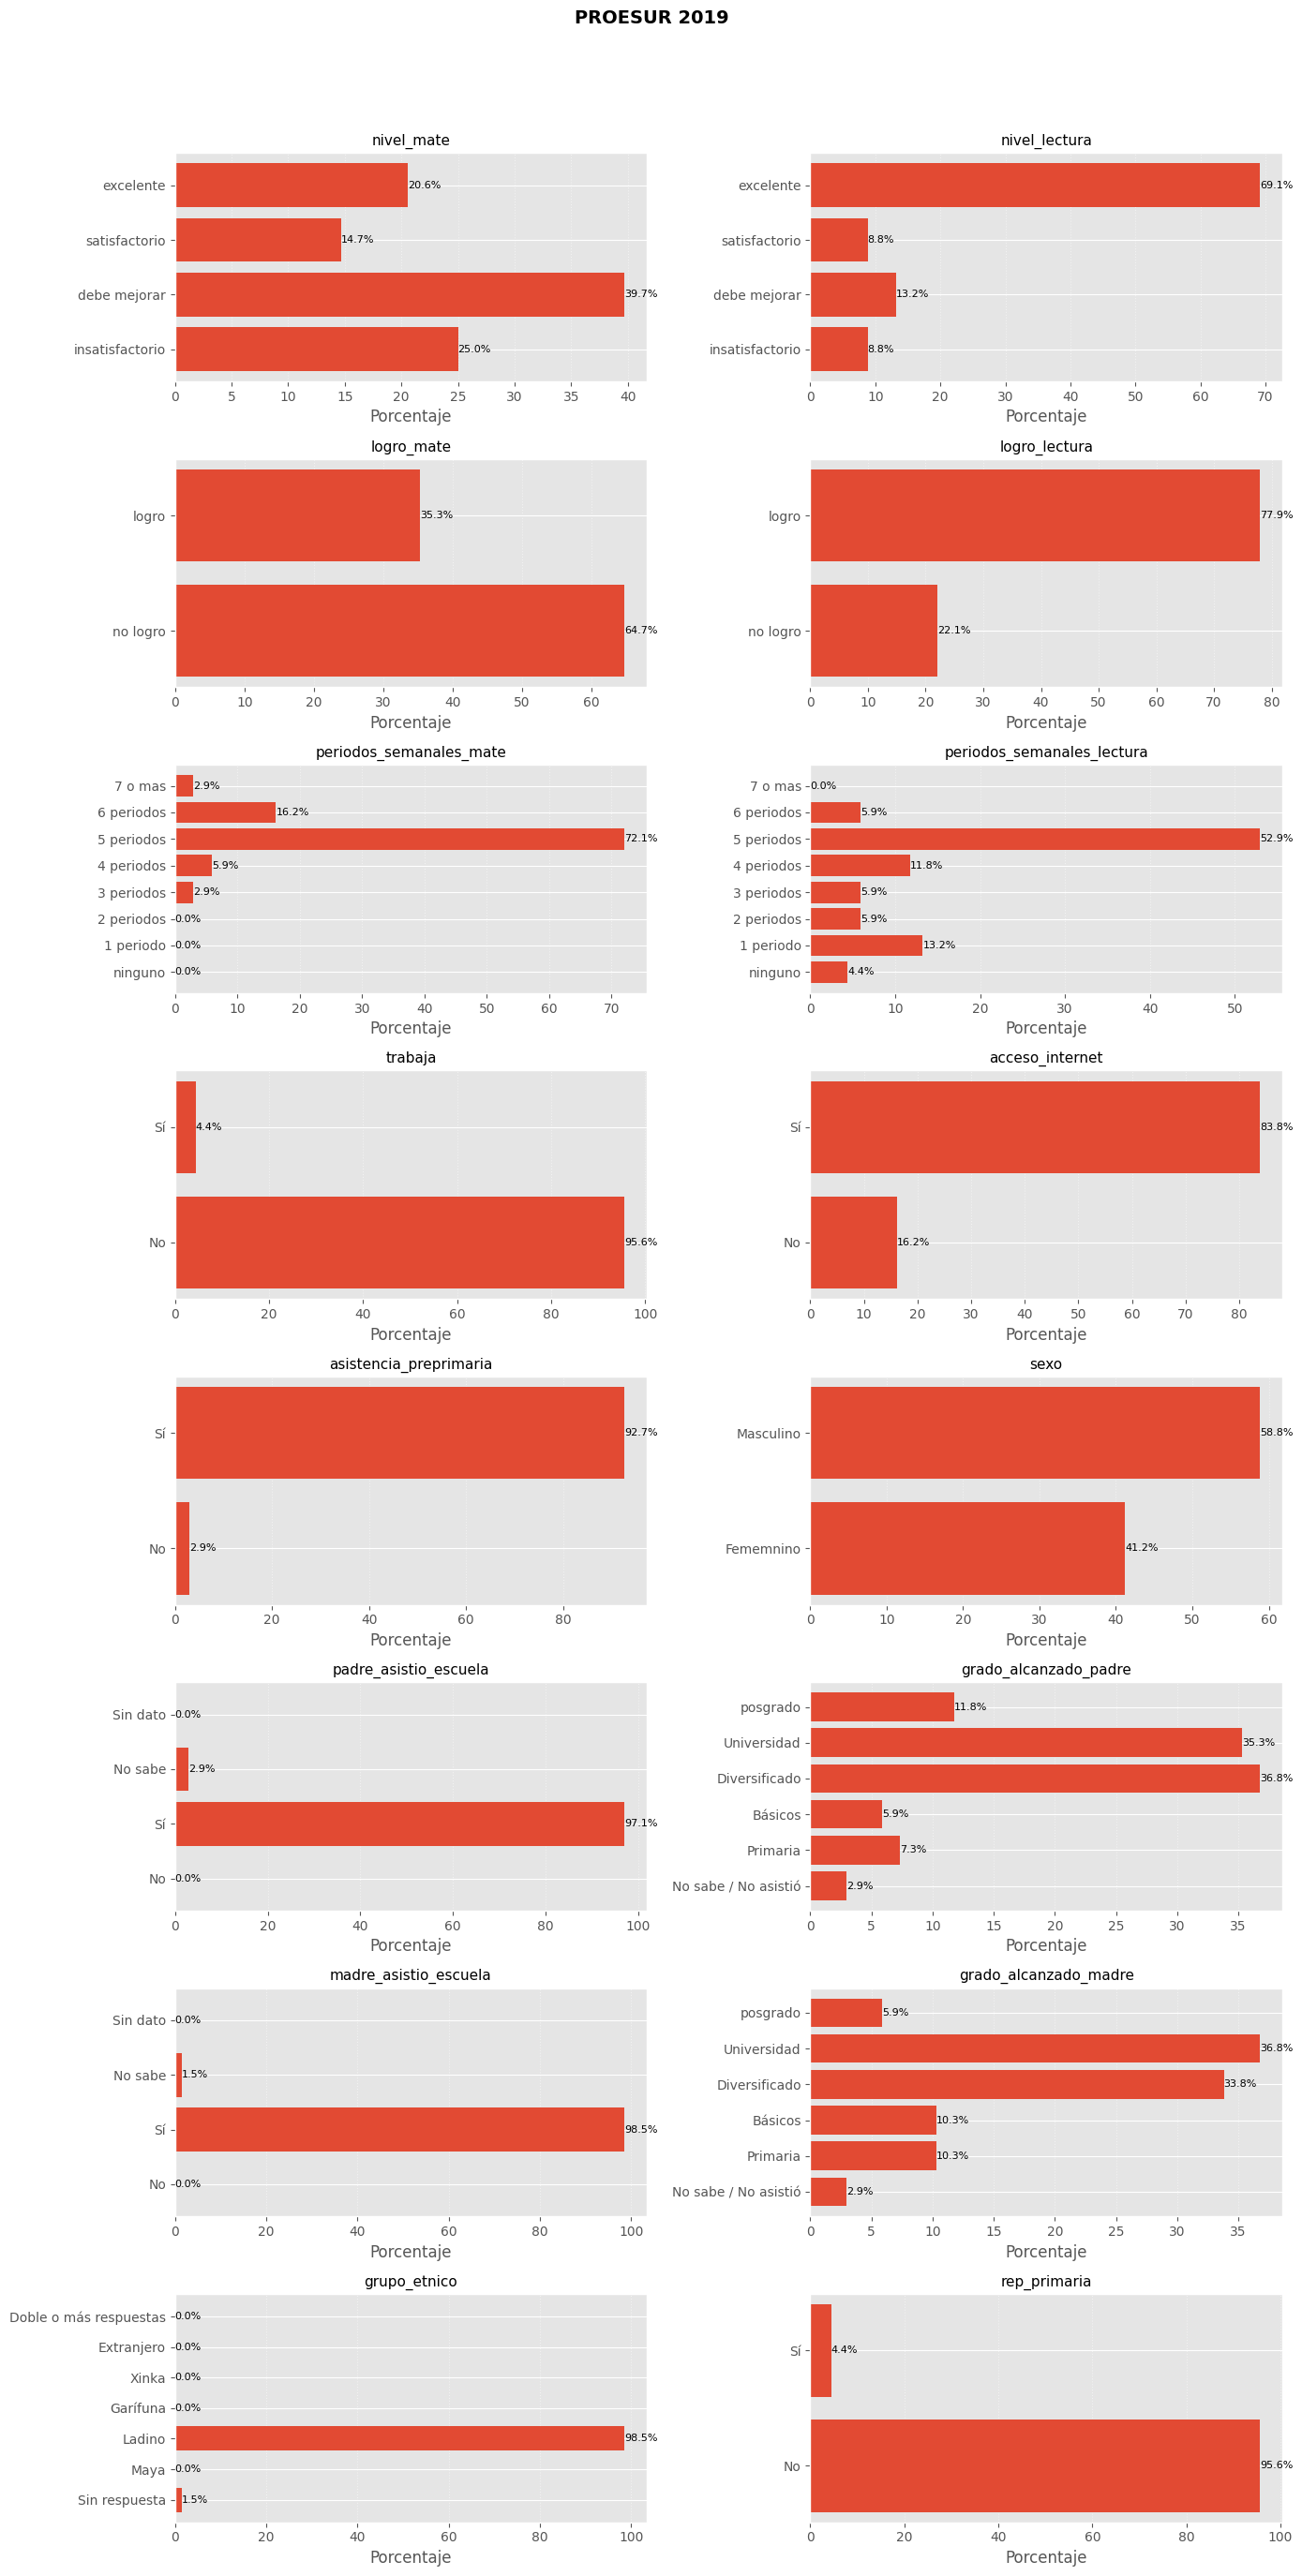

In [75]:
csv_path = Path("Extracted_data/metrics/2019-Grad-Internet.xlsx_filtered__metrics.csv")
plot_metrics_pretty(csv_path)

In [ ]:

def plot_metrics_ordered(path:Path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    for var, subdf in df.groupby("variable"):
        mapping = ALIASES_MAP.get(var)

        if mapping:
            # Expected categories in the desired order
            ordered_labels = list(mapping.values())

            # Current percentages from metrics
            s = subdf.set_index("category")["percent"]

            # Reindex to all expected labels, fill missing with 0
            s = s.reindex(ordered_labels, fill_value=0.0)

            cats = s.index
            perc = s.values
        else:
            # No mapping: keep whatever is there, sorted by percent
            subdf = subdf.sort_values("percent", ascending=True)
            cats = subdf["category"]
            perc = subdf["percent"].values

        
        match = re.search(r"\b(19|20)\d{2}\b", path.stem)
        year = match.group(0) if match else path.stem

        plt.figure(figsize=(7, 4))
        plt.barh(cats, perc)
        plt.title(f"{year} – {var}")
        plt.xlabel("Percent")

        for i, p in enumerate(perc):
            plt.text(p, i, f"{p:.1f}%", va="center", ha="left", fontsize=8)

        plt.tight_layout(rect=(0, 0, 1, 0.95))
        plt.show()

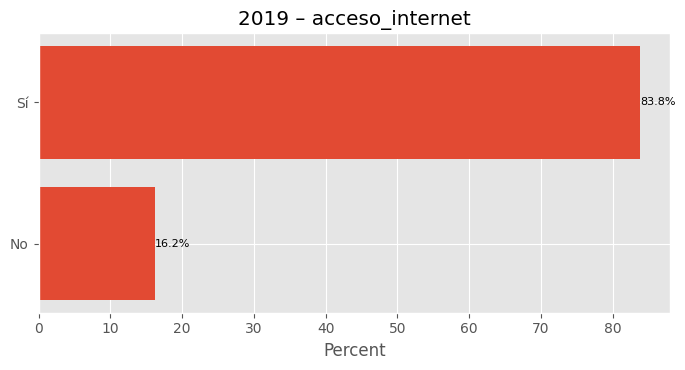

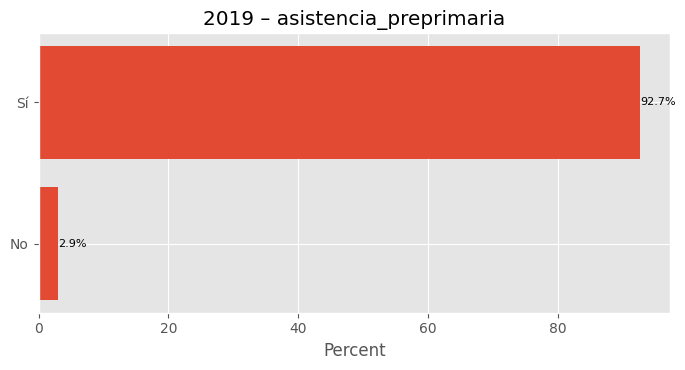

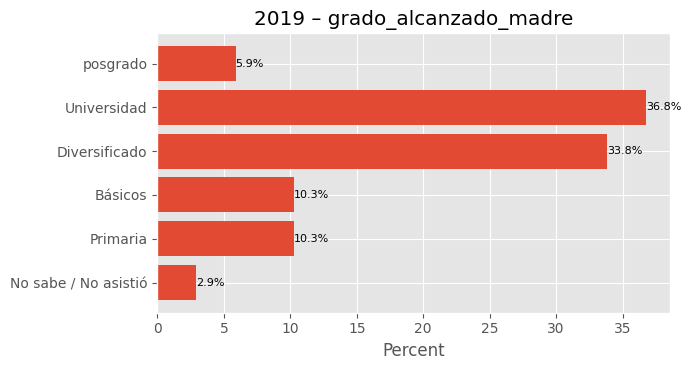

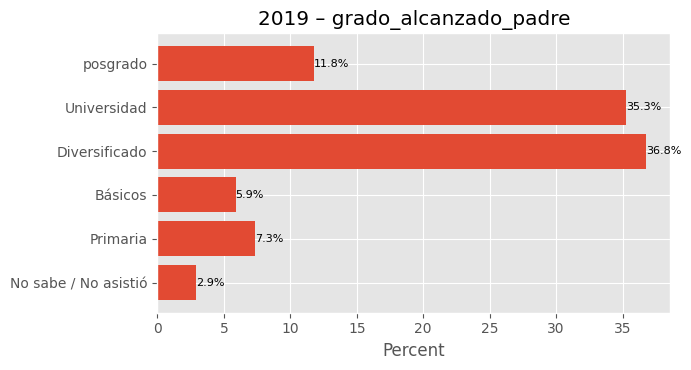

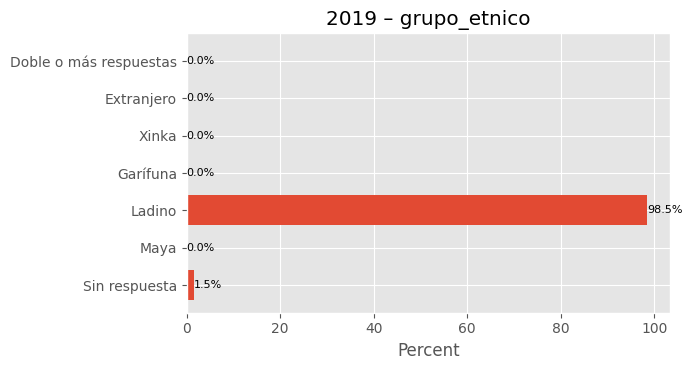

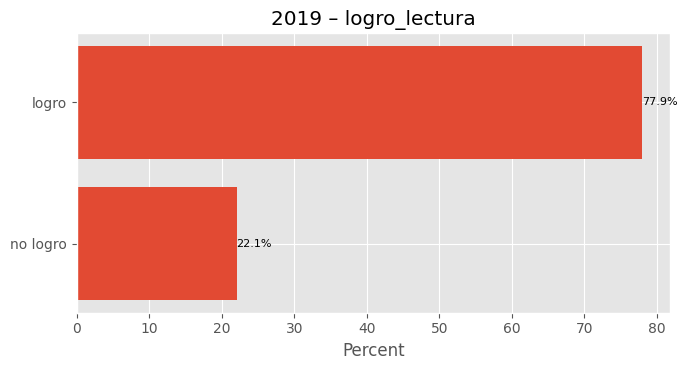

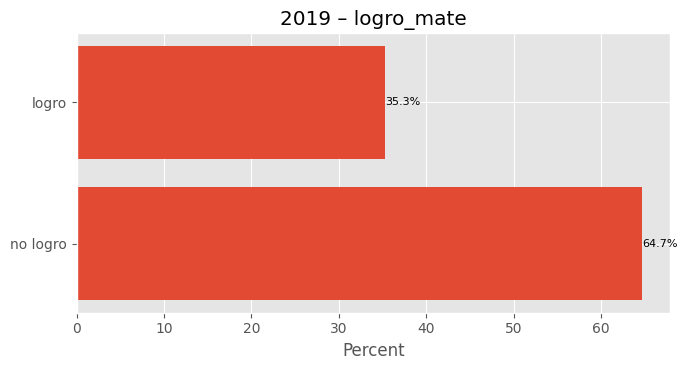

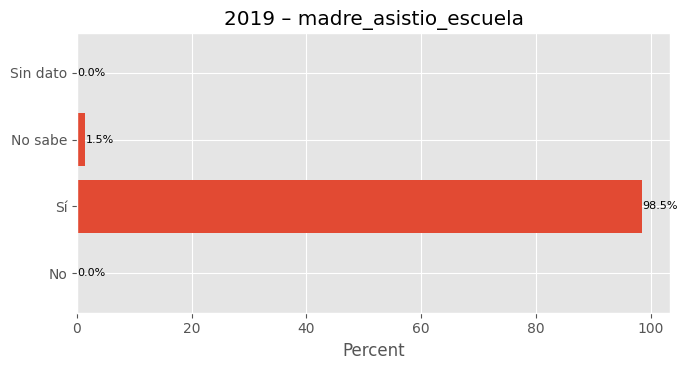

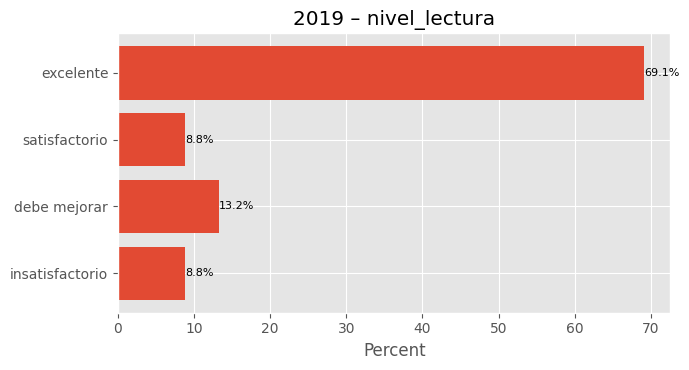

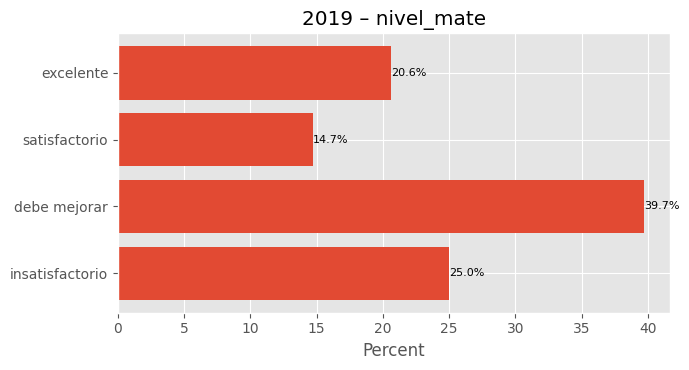

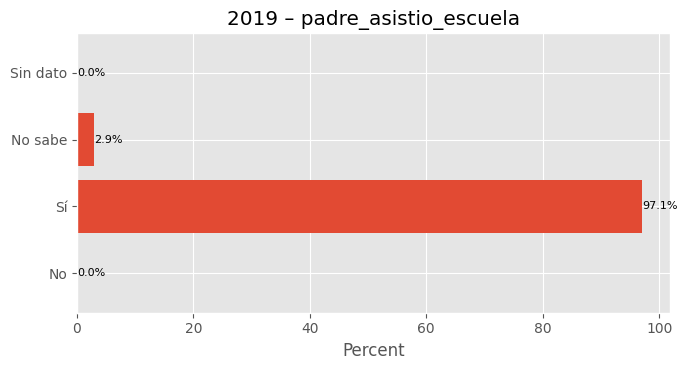

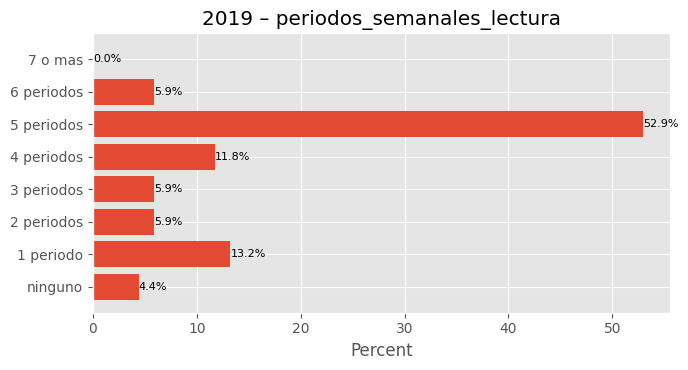

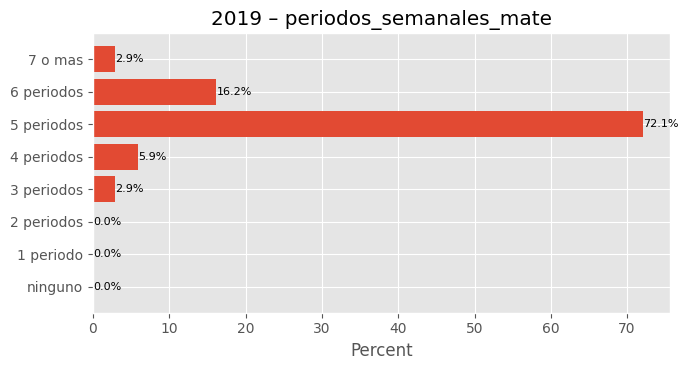

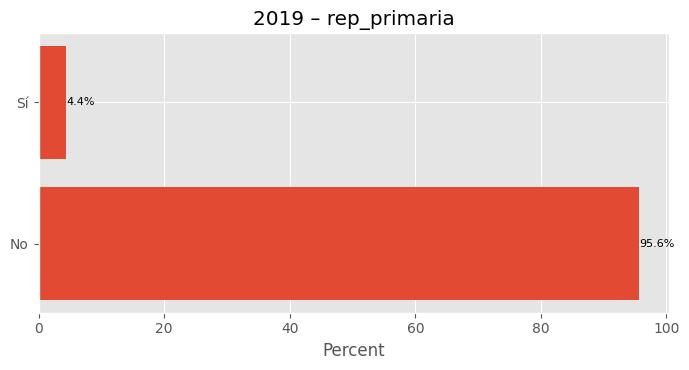

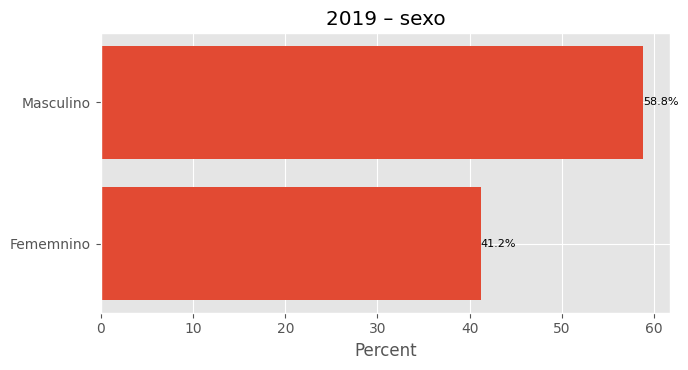

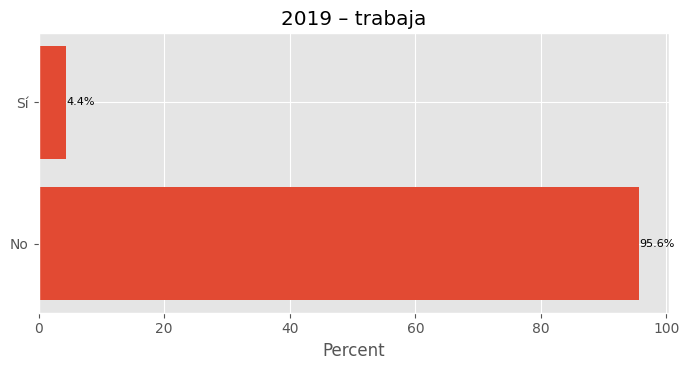

In [71]:
%matplotlib inline
csv_path = Path("Extracted_data/metrics/2019-Grad-Internet.xlsx_filtered__metrics.csv")
plot_metrics_ordered(csv_path)

In [15]:
# for csv_path in csv_files:
#     plot_varialbes(csv_path)